# **Classical interval estimation, limits, systematics Lecture 1 : exercises notebook**

This is the companion notebook to lecture 2 in the statistical course series, covering the following topics:
1. Maximum likelihood basics
2. Maximum likelihood for binned data
3. Maximum likelihood in the Gaussian case and chi2
4. Hypothesis testing basics

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1. Maximum likelihood for binned data

To illustrate Maximum Likelihood in practice, we consider an example with binned data. We take a simple model with signal and background:

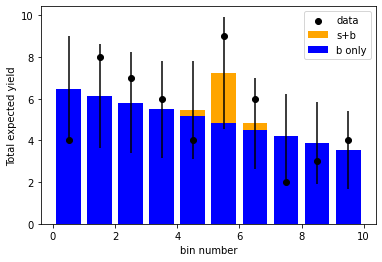

In [2]:
# Define the binning
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)

# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_fracs = b_yields/np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[4:7] = [ 0.1, 0.8, 0.1 ]

# Define the signal and background
s = 3
b = 50
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs

# Now generate some data for the s+b model
np.random.seed(14) # Set the random seed to make sure we generate the same data every time
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]

# Make a plot of the result
plt.bar(x, s_and_b, color='orange', yerr=np.sqrt(s_and_b), label='s+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

The plot above shows the typical case of a binned analysis: we have 2 *templates*, i.e. reference shapes for signal and background. These are given by bin fractions $f_{S,i}$ and $f_{B,i}$ which are normalized to 1. They are then scaled by the yields $s$ and $b$.

The ML estimate $\hat{s}$ corresponds to the "best fit" of the templates to the data, so one can more or less read it off the plot: naively, one expects something a bit larger than the $s=3$ value that is shown in the plot, perhaps $\hat{s} \approx 5$ or so.

We now check this by performing the ML estimation. A small change compared to the previous case is that instead of $L(s)$, we'll be using the quantity $\lambda = -2 \log L(s)$. The reason is as follows: first, the total PDF for all the bins together is a product of Poisson terms, one for each bin:
$$
L(s) = \prod_{i=1}^{n_{\text{bins}}} P(n_i, s f_{s,i} + b f_{b,i})
$$
Technically it's easier to deal with sums than products, and the log does this for us. As we'll see in a moment, this is also useful to deal with Gaussian PDFs, since in this case the log just extracts the squared term in the exponent. This is also the reason for the $-2$ term in the formula.
The only consequence in practical terms is that instead of $L(s)$ we compute $\lambda(s)$, and that we now want to minimize it instead of maximizing. But the ML estimate $\hat{s}$ remains the same, since the value of $s$ that maximizes $L(s)$ also minimizes $\lambda(s)$.

Let's not compute the ML estimate (best fit) $\hat{s}$ using $\lambda(s)$ :

hat{s}, ML = (5.100000000000007, 38.81476439657058)


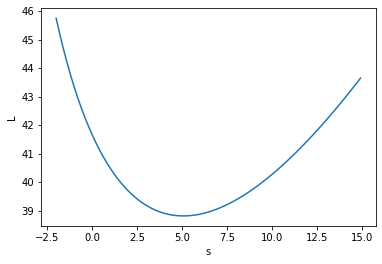

In [3]:
# Define the s scan
s_values = np.arange(-2, 15, 0.1)

# ==> Compute lambda for each value of s, plot the result and find the best-fit value among the values tested;
# ==> For later convenience, you may want to define a function lambda_s(s) that returns lambda as a function of s :

def lambda_s(s, data) :
    return sum( [ -2*np.log(scipy.stats.poisson.pmf(n, s*s_frac + b*b_frac)) for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )

lambda_values = np.array([ lambda_s(s_value, data) for s_value in s_values ]) # compute the likelihood (the Poisson PDF for each s)

# Plot the result
plt.plot(s_values, lambda_values)
plt.xlabel('s')
plt.ylabel('L')

# Find the maximum likelihood value in the list : merge the 2 lists and find the max based on the L value
from operator import itemgetter
print('hat{s}, ML =', min( [ (s,l) for s,l in zip(s_values, lambda_values) ], key=itemgetter(1)))

If all goes well, you should find a best-fit $\hat{s}$ of about 5. Of course this value is a bit imprecise due to the step size of 0.1 in the scan, but we can do better:

In [4]:
from scipy.optimize import minimize_scalar
# ==> Use the minimize_scalar function to find the minimum value. 
#     The syntax is minimize_scalar(func, (min, max)).x  (the .x returns the position of the minimum)
#     and 'func' should be the lambda_s function you defined above

You should find a best-fit value of about $\hat{s} = 5.06$. 

Note than since $L(s)$ was defined only up to a multiplicative factor, $\lambda(s)$ is defined up to an additive constant, so the value $\lambda(\hat{s})$ at the minimum isn't meaningful. On the other hand, the difference between values of $\lambda(s)$ at different $s$ is meaningful, and will be used later in hypothesis testing.

## 2. Hypothesis testing basics

So far we've focused on estimating parameters, but to get realistic results (including setting uncertainties on the best-fit values), we need an additional ingredient, *hypothesis testing*. The procedure for this is as follows:
* **Define the hypotheses to test**. We need two of them: a baseline *null* hypothesis, and an *alternate* which is tested against it
* **Define the *test* to perform** -- meaning the observables to use, and procedure to decide which hypothesis to accept.
* **Compute the result of the test for the observed data**, in particular the *p-value* of the test, and decide whether to accept the null or the alternate hypothesis.

To start with, we consider a simple Poisson counting process
* Define two different signal hypotheses ($n=0$ and $n=5$)
* Define the test in terms of the observed number of events: if it is less than some threshold, accept the null $n=0$, otherwise $n=5$.

For the study below, we consider a single-bin counting experiment. In this case the disciminant is just the observed count $n$.

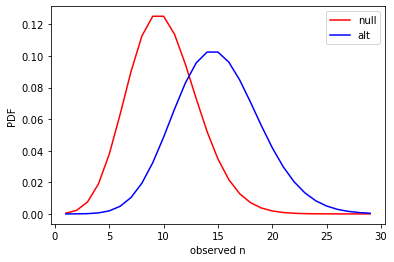

In [5]:
# Define the  hypotheses
b = 10 # background of 10 events
s_null = 0 # the null hypothesis: no signal, only background
s_alt  = 5 # the alternate hypothesis: 

# consider various values of the observed n (our discriminant)
ns = np.arange(1, 30, 1)

# ==> Compute and plot the PDFs for the two hypotheses. These are Poisson PDFs with parameters s_null + b and s_alt + b,
plt.plot(ns, scipy.stats.poisson.pmf( ns, s_null + b ), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf( ns, s_alt  + b ), color='b', label='alt')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();


As for any test, there are two ways to go wrong:
* Rejecting the null although it is true (false positive): the fraction of such cases is the *Type-I error rate* or *p-value*.
* Accepting the null although it is false (false negative) : : the fraction of such cases is the *Type-II error rate*, also (1 - Power)

A more stringent test reduces the Type-I error rate, but at the expense of an increased Type-II rate and vice versa. This is illustrated by the *ROC curve* which shows each error rate as a function of the other. The threshold for the test should be chosen depending on the desired balance between these error rates.

Type-I error (p-value) = 0.208444
Type-II error = 0.267611
Type-I error (p-value) = 0.0270416
Type-II error = 0.664123


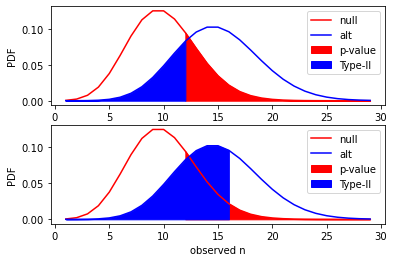

In [6]:

# First a loose test with a threshold at n=12 (i.e s=2)
# ==> Compute the Type-I error probability (p-value) and the Type-II error probability for 2 tests
#     Recall that the p-value is the integral of the null hypothesis PDF above the threshold, so given by scipy.stats.poisson.sf(threshold, s_null+b)
#       and the Type-II error is the integral of the alt. hypothesis PDF below the threshold,  so given by scipy.stats.poisson.cdf(threshold, s_alt+b)
plt.figure()
plt.subplot(211)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')

threshold1 = 12
lo1 = np.arange( 1, threshold1 + 1, 1)
hi1 = np.arange(threshold1, 30, 1)
plt.fill_between(hi1, scipy.stats.poisson.pmf( hi1, s_null + b ), color='r', label='p-value')
plt.fill_between(lo1, scipy.stats.poisson.pmf( lo1, s_alt  + b ), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();
print('Type-I error (p-value) = %g' % scipy.stats.poisson.sf(threshold1, s_null + b) )
print('Type-II error = %g' % scipy.stats.poisson.cdf(threshold1, s_alt + b) )

# Then a more stringent test with a threshold at n=16 (i.e s=6)
plt.subplot(212)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')

threshold2 = 16
lo1 = np.arange( 1, threshold2 + 1, 1)
hi1 = np.arange(threshold2, 30, 1)
plt.fill_between(hi1, scipy.stats.poisson.pmf( hi1, s_null + b ), color='r', label='p-value')
plt.fill_between(lo1, scipy.stats.poisson.pmf( lo1, s_alt  + b ), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();
print('Type-I error (p-value) = %g' % scipy.stats.poisson.sf(threshold2, s_null + b) )
print('Type-II error = %g' % scipy.stats.poisson.cdf(threshold2, s_alt + b) )

thresholds = np.arange(1, 30, 1)
# ==> Compute the Type-I and Type-II error probabilities for each threshold in the list above, and plot the ROC curve


The threshold for discovery in physics is often set at $5\sigma$, which corresponds to a p-value of about $3 \cdot 10^{-7}$. What threshold would one use to get so small a Type-I error rate ?

In [7]:
pfive = scipy.stats.norm.sf(5)
threshold_five = scipy.stats.poisson.isf(pfive, s_null + b)
print('pvalue=', pfive, 'threshold=', threshold_five, 'power=', scipy.stats.poisson.sf(threshold_five, s_alt + b))

pvalue= 2.866515718791933e-07 threshold= 29.0 power= 0.0004184496683276901


You should find $n_{\text{obs}} \ge 29$. If we do osberve such a large n, then we can indeed reject the null at with a p-value corresponding to a $5\sigma$ threshold. This corresponds to testing for discovery: we reject the no-signal hypothesis in favor of an hypothesis with non-zero signal.

However the power of the test is also very low (you should have found about $4\, 10^{-4}$ above), which means that even if the $s=5 $signal is there, we are very unlikely to observe an event count of $n_{\text{obs}} \ge 29$. The underlying problem that is causing this is the fact that the different between the alternate hypothesis $s=5$ and the null $s=0$ is quite small on the scale of the measurement uncertainties, so the two hypotheses are difficult to separate.

If the alternate hypothesis was larger, say $20$ signal events, then things would be easier. The threshold for discovery would still be 29 events (this only depends on the null, not the alt), but now the power would be:

In [8]:
s_alt2 = 20
pfive = scipy.stats.norm.sf(5)
threshold_five = scipy.stats.poisson.isf(pfive, s_null + b)
print('pvalue=', pfive, 'threshold=', threshold_five, 'power=', scipy.stats.poisson.sf(threshold_five, s_alt2 + b))

pvalue= 2.866515718791933e-07 threshold= 29.0 power= 0.52428301389368


You should find that the power is about 50% -- i.e. this means that if $s_{\text{alt}} = 20$ is indeed true, then we have an approximately 50% chance of obtaining $n \ge 29$ and therefore of making the discovery.

## 3. Testing for discovery in a histogram

Now that we have a general technique, let's apply all this to the full binned distribution above:

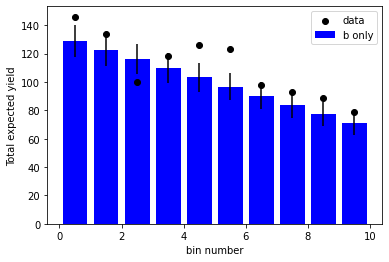

In [9]:
# Define the binning
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)

# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_fracs = b_yields/np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]

# Specify signal and background yields
s = 70
b = 1000
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs

# Generate a dataset
np.random.seed(6) # make sure we always generate the same
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]
plt.bar(x, b_only, yerr=np.sqrt(b_only), color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

We can now compute the best-fit $\hat{s}$ and from it the value of $t_0$, and use this to compute the significance of the signal

In [10]:
from scipy.optimize import minimize_scalar

from scipy.optimize import minimize_scalar
s_hat = minimize_scalar(lambda s: lambda_s(s, data), (0, 200)).x
print('exact hat{s}:', s_hat)

# Compute and print t0, z, and the p-value
q0 = lambda_s(0, data) - lambda_s(s_hat, data)
print('q0 =', q0, 'z =', np.sqrt(t0), 'p-value =', scipy.stats.norm.sf(np.sqrt(q0)))

# Compute the s_hat+b shape and plot the result
hats_plus_b = s_hat*s_fracs + b_only
plt.bar(x, hats_plus_b, yerr=np.sqrt(hats_plus_b), color='orange', label='Best-fit s + b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

exact hat{s}: 62.62713906897173


NameError: name 't0' is not defined